# Natural Scenes Classification Using CNNs
***

## Introduction

This project explores the use of convolutional neural networks (CNNs) for image classification on a real-world dataset of natural scene images. The objective is to train a model that can accurately categorize input photographs into one of six scene categories: buildings, forest, glacier, mountain, sea, or street.

Two models are developed and compared:
- A custom CNN built from scratch
- A transfer learning model using VGG16 pretrained on ImageNet

The goal is not just to build a working classifier, but to evaluate trade-offs between these two approaches — including performance, training efficiency, and generalization on unseen data.

### Dataset Description 

The dataset, sourced from Kaggle, consists of approximately **25,000 images** of natural scenes collected from around the world. It is divided into training (~ 14,000 images), testing (~ 3,000 images), and prediction (~7,000 images) sets. Each image  is labeled into one of six classes:

- Buildings  
- Forest  
- Glacier  
- Mountain  
- Sea  
- Street  

📂 **Dataset Link**: [Intel Image Classification on Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

**Note:** Only the training and testing subsets are used in this project, as they contain ground-truth labels. The prediction set is unlabeled and was excluded, since it does not contribute to model training or evaluation. It could be used in the future for extended inference or qualitative analysis.

## Exploratory Data Analysis 

### Importing Libraries For Data Loading, EDA and Image Prep

In [1]:
# Core libraries

import os 
import random
from random import sample
import numpy as np
import pandas as pd

# Image processing
import cv2 
from PIL import Image 

# Visualization
import matplotlib.pyplot as plt 


### Dataset Preview: Structure, Class Overview & Sample Visualization

In [2]:
# === Dataset Visualization Function ===
# Displays one random image per class from the training directory
# Helpful for quickly validating class structure and spotting anomalies

path = '../data/train' # Root directory containing class subfolders

def display_images(path):
    # Get class folder names, filter out any non-directories
    class_names = os.listdir(path) 
    class_names = [cls for cls in class_names if os.path.isdir(os.path.join(path, cls))]
    
    # Set up a 2x3 grid for displaying sample images
    fig, axes = plt.subplots(2, 3, figsize=(12, 8)) 
    axes = axes.flatten() 

    for idx, class_name in enumerate(class_names): 
        class_path = os.path.join(path, class_name) 
        image_files = os.listdir(class_path) 
        random_image = random.choice(image_files) 
        image_path = os.path.join(class_path, random_image) 

        # Open and display the image
        image = Image.open(image_path).convert('RGB') 
        axes[idx].imshow(image) 
        axes[idx].set_title(class_name) 
        axes[idx].axis('off') 

    plt.tight_layout() 
    plt.show() 
    

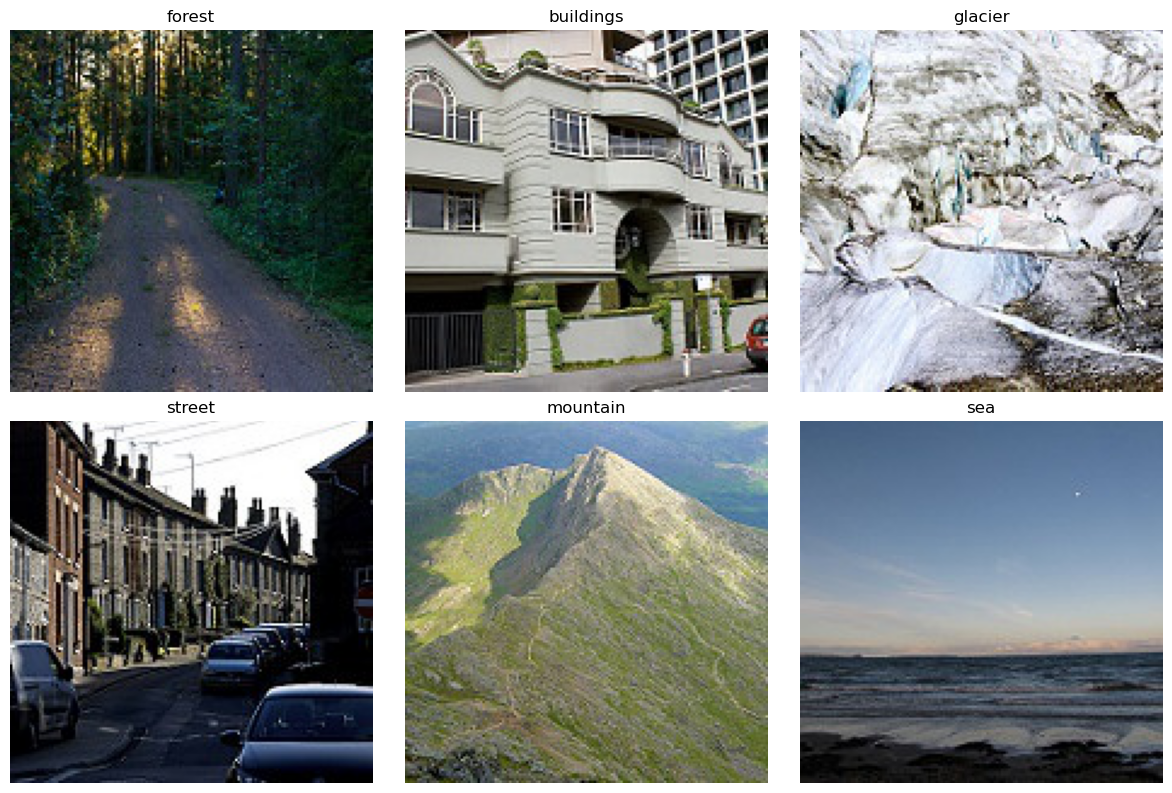

In [3]:
display_images(path) # Let's see what we're working with.

### Summary

The training data is organized into clearly labeled folders by class, which simplifies loading and preprocessing. Each folder corresponds to a unique natural scene category, and sample visualizations confirmed that image content generally aligns with the assigned labels. This structure supports direct use of directory-based data generators in the next stage.

### Observation

Some images in the dataset appear low-resolution or slightly blurry. This could affect the model’s ability to learn finer visual features, particularly in categories where texture or edge sharpness is important (e.g., forest vs. street). Further evaluation during model training will help determine whether image quality has a measurable impact on classification performance.


### Class Distribution Overview

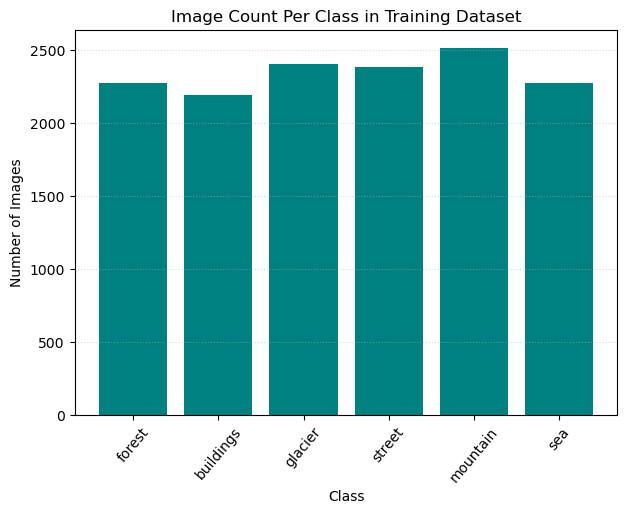

{'forest': 2271, 'buildings': 2191, 'glacier': 2404, 'street': 2382, 'mountain': 2512, 'sea': 2274}


In [4]:
# === Number of Images Per Category in the Training Set ===

path = '../data/train'

# Get class folders excluding non-directories
class_names = os.listdir(path) 
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(path, cls))]

counts = [] 

# Count valid image files inside each class folder
for class_name in class_names:
    class_path = os.path.join(path, class_name)
    image_files = os.listdir(class_path) 
    
    count = 0 
    
    for file in image_files:
        if os.path.isfile(os.path.join(class_path, file)): 
            count += 1
    counts.append(count)
    
    
# Plot the class distribution as a bar chart

plt.figure(figsize=(7, 5))
plt.bar(class_names, counts, color="teal")
plt.title("Image Count Per Class in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.rc('xtick', labelsize=8)   
plt.rc('ytick', labelsize=8)
plt.xticks(rotation=50) 
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

# Print a dictionary mapping class name to image count    

print(dict(zip(class_names, counts))) 



### Observations 

Based on the class distribution:

`{'forest': 2271, 'buildings': 2191, 'glacier': 2404, 'street': 2382, 'mountain': 2512, 'sea': 2274}`

The dataset appears to be relatively well-balanced, with each class containing between 2100 and 2500 images. Although the 'mountain' class has the highest count, the difference is not significant enough to require class weighting or other methods that would otherwise make up for the imbalance. This balance should help the model learn features from all classes without developing a strong bias toward any single category.


### Image Shape Consistency

--- Checking image size uniformity across classes

In [5]:
from collections import Counter

path = '../data/train'
class_names = os.listdir(path)
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(path, cls))] 
sizes = [] # Store (width, height) tuples for each sample image

# Sample 3 random images from the first 3 classes and record their sizes
for class_name in class_names[:3]:
    class_path = os.path.join(path, class_name) 
    image_files = os.listdir(class_path) 
    sample_images = random.sample(image_files, 3) 
    
    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        sizes.append(image.size)  
        
# Count how often each size occurs
size_counts = Counter(sizes)

print("Image size counts:")
print(size_counts)

Image size counts:
Counter({(150, 150): 9})


### Observations

Although the dataset source indicates that all images are sized 150×150, I performed a quick shape consistency check across a few classes to confirm this. While not strictly necessary, this step served both as a safeguard against outliers and as a useful exercise in verifying dataset assumptions.

Regardless of the results, all images will still be resized during preprocessing to ensure uniformity and prevent downstream issues during model training.



### EDA Summary

The dataset appears well-structured and balanced across classes, with only minor variation in image counts. Sample visualizations confirmed that class labels are accurately represented, and image dimension checks validated the expected 150×150 sizing. While minor OS-specific files (e.g., `.DS_Store`) were present, they were filtered out during preprocessing. Overall, the dataset is clean and ready for model training with minimal risk of input inconsistency.

#### Final Notes

Some code cells (e.g., path setup and class definitions) are repeated across sections to ensure each block is independently runnable. This approach was intentional during the exploratory phase to support step-by-step testing and debugging. In a production context, these would typically be consolidated into a setup script or initialization cell for cleaner structure.

### Data Preprocessing

In [6]:
# === Library Imports: Model & Image Preprocessing ===
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

### Preprocessing Configuration


In [7]:
# Set global preprocessing parameters

INPUT_SIZE = 150 # Target image dimensions (150x150)
BATCH_SIZE = 64  # Number of images processed per batch

# Set random seed for reproducibility
SEED =12345
np.random.seed(SEED) 

# Get class names from training directory (filtering out non-directories)
path = '../data/train'
classes = os.listdir(path)
myclasses = [cls for cls in classes if os.path.isdir(os.path.join(path, cls))] #filter out non-directories

# Total number of target classes
NUMCLASSES = len(myclasses)

# Create index-to-label mapping for visualization and evaluation
mapping = { i: cls for i , cls in enumerate(myclasses)} 

### Parameter Setup and Justification

All images were resized to 150×150 to ensure input consistency and reduce computational overhead. This standardization allows the model to process input data efficiently without needing to adapt to varying image dimensions.

Given the size of the dataset and hardware constraints, the batch size was set to 64 — a value that provided a good balance between training speed and system stability. An initial batch size of 32 led to noticeably slower performance, prompting experimentation with higher values. Batch size 64 delivered faster training without overwhelming resources.

To ensure reproducibility, a random seed (`12345`) was set, keeping data shuffling and sampling consistent across runs. A class index-to-label mapping was also created to support more interpretable evaluations (e.g., confusion matrices) later in the workflow.

### ImageDataGenerator Configuration

In [22]:
# Augmentation + preprocessing setup for custom CNN

custom_train_datagen = ImageDataGenerator(
                                    rotation_range=15, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    fill_mode='nearest',
                                    horizontal_flip=True,
                                    rescale=1./255,
                                    validation_split=0.2
                                    )


### Image Generators for Training and Validation 

In [23]:
# Configure data generators to feed augmented image batches to the custom CNN during training and validation

train_generator = custom_train_datagen.flow_from_directory(
                                                    path,
                                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=SEED,
                                                    subset='training'
                                                    )

val_generator = custom_train_datagen.flow_from_directory(
                                                    path,
                                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False, #set to false for cm predictions
                                                    seed=SEED,
                                                    subset='validation'
                                                    )


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


### Summary

Following the preprocessing setup, I used Keras's `ImageDataGenerator` class to apply in-place data augmentation. This includes a variety of transformations—such as rotations, width and height shifts, shearing, zooming, and horizontal flips—to diversify the dataset and improve the custom CNN model's ability to generalize.

An 80/20 training-validation split was applied using Keras’s built-in subset parameters, avoiding the need for manual data separation. 

In an earlier iteration of the project, I used `flow_from_dataframe()` with a manually constructed DataFrame of image paths and labels. I later switched to `flow_from_directory()`, which integrates more naturally with the dataset’s folder structure, reduces the risk of errors from custom DataFrame formatting, and aligns with standard Keras image pipelines.


## Baseline CNN: Architecture, Training & Archived Metrics

In [24]:
# Defining a custom CNN architecture for multi-class image classification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential([
    
    # Convolution Block 1: Basic edge detection 
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    # Convolution Block 2: Texture and pattern extraction
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolution Block 3: High-level feature learning
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten feature maps and connect to dense layers
    Flatten(),
    
    # Transforms extracted features into class-level predictions
    Dense(1024, activation='relu'),
    
    # Prevents overfitting by randomly deactivating neurons
    Dropout(0.5),
    
    # Final classification layer - maps final scores to class probabilities
    Dense(NUMCLASSES, activation='softmax')
])


### Convolutional Neural Network Architecture Summary

I built a custom CNN to experiment with its architecture and observe how changes affect performance, training speed, and accuracy. This model will later be compared with a pretrained VGG16 model using transfer learning to evaluate differences in efficiency, accuracy, and generalization behavior.

As a starting point, three convolutional layers were chosen — deep enough to extract meaningful features without risking excessive overfitting or overcomplicating the model for a dataset of this size. The first Conv2D layer focuses on low-level features like edges, the second on textures and simple patterns, and the third on more complex shapes and structures.

The number of filters increases across these layers: 32 → 64 → 128. This scaling is intentional — early layers use fewer filters to capture basic features, while deeper layers require more filters to extract more complex and abstract patterns. If the model shows signs of overfitting (e.g., high training accuracy but low validation accuracy), I plan to reduce the number of filters or introduce additional regularization.

Each Conv2D layer is followed by a MaxPooling2D layer to reduce spatial dimensions of the feature maps and computational complexity. Pooling helps condense learned features and limits the total number of parameters, improving efficiency.

To help prevent overfitting—especially on a relatively small dataset— I added a Dropout layer (rate = 0.5) after the fully connected Dense layer. This randomly deactivates 50% of the neurons during training, encouraging the model to generalize by relying on multiple neurons to represent features. 

The final Dense layer uses a `softmax` activation function to convert the model’s raw output scores into a probability distribution across the six classes. This ensures each image is assigned a predicted label based on the highest probability. 

The output layer size is defined by the variable `NUMCLASSES`, which matches the number of unique class labels in the training data. The input shape is (150, 150, 3) — chosen to preserve sufficient visual detail from the natural scene images while keeping the input manageable for computation. Reducing the input dimensions further could strip away important visual features necessary for accurate classification.


In [25]:
# === Model Compilation ===

from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    loss = 'categorical_crossentropy',             # suitable for multi-class classification
    optimizer = RMSprop(learning_rate = 0.0001) ,  # small learning rate for gradual, stable convergence
    metrics = ['accuracy', Precision(), Recall()]  # classification evaluation metrics
    )
 
# Set training duration
num_epochs = 6 

In [26]:
# === Setup: Save the best model weights during training ===

from tensorflow.keras.callbacks import ModelCheckpoint

# Define a callback to monitor validation loss and save the best model weights
checkpoint_cb = ModelCheckpoint(
    '../models/cnn_weights_best.h5',          # Filepath to save the best weights
    save_best_only=True,            # Only save weights if val_loss improves(lowers)
    monitor='val_loss',           
    mode='min',                     # Save when validation loss decreases
    verbose=1                       # Print update when a new best model is saved
)


# === Train the model ===
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    callbacks=[checkpoint_cb]      # Use checkpoint callback during training
)

# === Save final weights after training completes ===
model.save_weights("../models/cnn_weights_final.h5") # Save weights from final epoch
print(f"Saved model weights after {num_epochs} epochs.")

In [243]:
# Reloading best saved weights for CM evaluation (original training metrics were lost)
model.load_weights('../models/cnn_weights_best.h5')  

In [ ]:
# Visualizing the metrics of the first model training run 
history.history.keys()

In [ ]:
# === Plot Training vs Validation Metrics ===
import seaborn as sns
sns.set_style('darkgrid')

# Create 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training & Validation Metrics - Custom CNN', fontsize=16)

# Plot 1: Loss
axs[0, 0].plot(history.history['loss'], label='Train Loss', color='goldenrod') #
axs[0, 0].plot(history.history['val_loss'], label='Val Loss', color='darkslategray')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Accuracy
axs[0, 1].plot(history.history['accuracy'], label='Train Acc', color='orangered')
axs[0, 1].plot(history.history['val_accuracy'], label='Val Acc', color='mediumblue')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Precision
axs[1, 0].plot(history.history['precision_4'], label='Train Precision', color='mediumseagreen')
axs[1, 0].plot(history.history['val_precision_4'], label='Val Precision', color='darkcyan')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Recall
axs[1, 1].plot(history.history['recall_4'], label='Train Recall', color='deeppink')
axs[1, 1].plot(history.history['val_recall_4'], label='Val Recall', color='dodgerblue')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust legend and title font sizes for all subplots for readability
for ax in axs.flat:
    ax.legend(fontsize=10)
    ax.title.set_fontsize(14)

# Display plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to fit titles
plt.show()

### Metrics Analysis & Training Reflection

#### Overview

This section analyzes the custom CNN's performance over its initial 6 training epochs. The goal is to highlight its strengths, identify early signs of overfitting, and guide decisions for retraining and model adjustments.

#### Loss & Accuracy Trends

To evaluate learning progress, I examined both the loss and accuracy curves. Training and validation loss steadily decreased — a promising sign that the model was learning effectively. However, validation loss began to rise slightly at epoch 6, suggesting early signs of overfitting. This is typical behavior: as training continues, models may begin to memorize training patterns at the expense of generalization.

The accuracy plot reflects the same pattern. Training accuracy rose consistently, while validation accuracy fluctuated early on, peaked around epoch 5, and dipped slightly afterward. This crossover suggests that epoch 5 may have been the optimal training point for this model.


#### Precision & Recall Dynamics

Precision dropped significantly in the early epochs, recovered mid-training, then dipped again at the end. Validation precision consistently lagged behind training. This suggests that the model became overconfident- making more false positives, likely due to limited regularization or confusion between visually similar classes.

In contrast, recall steadily improved throughout training, with validation recall eventually surpassing training. This implies the model became better at identifying relevant classes, but at the cost of increased false positives. In a real-world scenario, this tradeoff could be risky — especially in domains where false positives carry high consequences. Moving forward, I’ll aim to improve precision, even if it slightly reduces recall.


#### Best Epoch + Generalization

All key metrics peaked or stabilized around epoch 5 during the first training run. This suggests the model had reached its best generalization point before overfitting began, as shown by the dip in metrics during the final epoch. This inflection point (epoch 5) serves as a benchmark for future retraining and helps determine when the model stops generalizing effectively.

#### Next Steps

I plan to visualize predictions using a confusion matrix on the validation data. This will help identify which classes are most frequently misclassified and where false positives tend to occur.

#### Final Thoughts

Compared to the first iteration of this project, this version of the model trains faster, behaves more predictably, and provides clearer signals for improvement. Together, these gains lay a solid foundation for future model tuning and deeper evaluation.

### Class Confusion Matrix 

2025-05-27 11:02:20.033258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


44/44 [==============================] - 9s 195ms/step


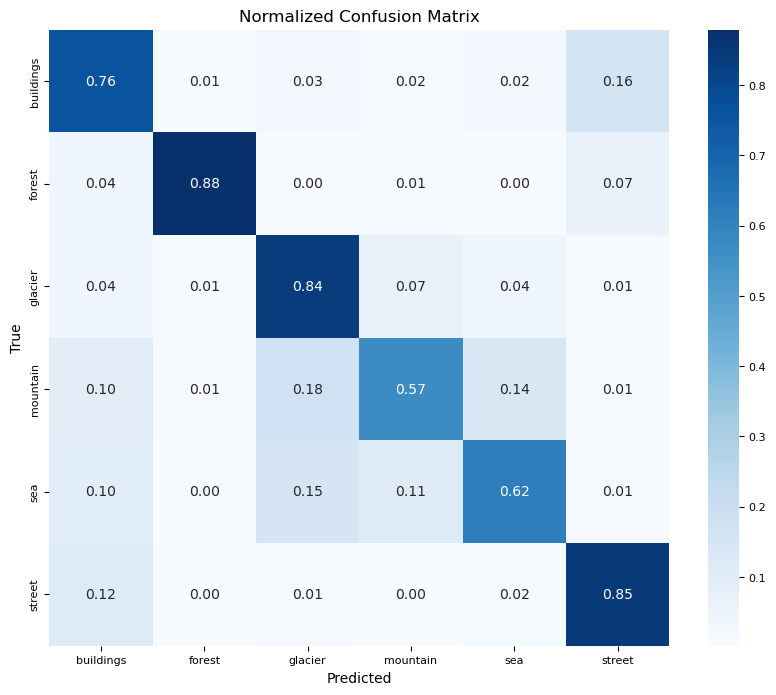

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Extract true class labels from the validation generator
true_labels = val_generator.classes

# Predict class probabilities for the validation set
predicted_probs = model.predict(val_generator, verbose=1)

# Convert probabilities to class predictions
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to show percentages per class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create labeled DataFrame for heatmap visualization
labels = list(val_generator.class_indices.keys())  #get class names
df_cm = pd.DataFrame(cm_norm, index=labels, columns=labels)

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt=".2f", cmap = 'Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Confusion Matrix Analysis - Before Retraining

The model performs reasonably well on classes like forest, glacier, and street, which show comparatively stronger diagonal values in the confusion matrix—suggesting decent confidence and lower misclassification rates. 

However, several classes like mountain and sea reveal persistent confusion, often misclassified into each other or other background-heavy categories. This suggests that the model struggles when class-defining features are lost in cluttered or visually shared scenery. While it’s gaining confidence with certain classes, it tends to slip in environments where background details distract more than they help.

A standout confusion is between buildings and streets. About 16% of actual 'building' images were misclassified as 'street'. While this might seem minor in isolation, it’s a critical flaw in real-world applications like autonomous driving, where distinguishing between structures and roadways is essential. This confusion likely stems from contextual overlap in the dataset: buildings often appear along streets, making it difficult for the model to isolate building-specific features.

The model struggles more significantly with the mountain and sea classes. 'Mountain' images were frequently predicted as 'sea', 'glacier' or even 'building'— likely due to shared visual features like white snowcaps, sharp architectural shapes or proximity to other natural scenes. 

Similarly, the sea class was confused with glacier and mountain with considerable frequency, especially in coastal images that include cliffs or snowy backdrops. These mix-ups likely stem from background elements appearing across multiple classes which result in the model latching onto shared dominant textures (snow, rocks, water) rather than the defining class features. 

Originally, I suspected that class imbalance might be responsible since some classes like 'sea' had slightly fewer samples.However, mountain — the most frequent class — was still one of the most misclassified. This suggests the issue isn’t quantity, but quality and learnability: either the features aren’t distinct enough, or the model lacked the time or depth to fully learn them in just six epochs.

Overall, the confusion matrix reveals that model has learned some core patterns, but struggles when features overlap across classes or when visual context (like background) interferes with class identity. This highlights the limitations of augmentation alone and suggests a need for better regularization, deeper learning, or a more diverse dataset. These findings will directly shape my retraining strategy — targeting specific confusion zones and refining how the model learns class-defining features through extended training.

The matrix doesn’t just show errors — it exposes the model’s assumptions about which features matter most, and where it's relying on visual shortcuts. These insights will directly shape the structure and strategy of my retraining phase.

### Note on Missing Plots

Due to re-running cells and not consistently saving the metrics history object, the original training run metrics and visualizations were lost. As a result, the model was retrained from scratch — which aligned naturally with the project workflow.

The first run was primarily for experimentation and understanding how a custom CNN behaves given my current hardware constraints. After reviewing its performance, I made targeted changes to improve generalization and reduce overfitting.

This note documents that decision and maintains transparency in the development process. The retraining used the same architecture and data pipeline, with minor adjustments based on insights from the initial round. All performance plots and metrics below reflect this updated training cycle.


---

## Custom CNN II: Second Iteration for Improved Generalization

Based on the performance and error patterns observed during the first training run, this strategy outlines the key changes I will implement to improve generalization and reduce misclassification—particularly among visually similar classes.

#### **Increase Training Duration**

The initial model trained quicly without signs of overfitting. I will extend the number of training epochs to allow deeper feature learning, particularly to help the model differentiate classes with overlapping visual contexts (e.g., 'mountain' vs. 'sea'). The aim is to reduce the performance delta between training and validation while refining learned representations.

#### **Increase Dropout to 0.55**

By increasing dropout (from 0.5 to 055), I'm introducing more regularization to minimize overconfident predictions. While it may slightly impact recall, it's a calculated tradeoff to encourage the model to generalize features rather than memorize patterns—— particularly for tricky classes like 'sea', 'mountain', and 'building'.

In [142]:
# Clear last training session from memory
import tensorflow.keras.backend as K
K.clear_session() 
del history 

### Preprocessing Configuration II


In [143]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Set global preprocessing parameters

INPUT_SIZE = 150 # Target image dimensions (150x150)
BATCH_SIZE = 64  # Number of images processed per batch

# Set random seed for reproducibility
SEED =12345
np.random.seed(SEED) 

# Get class names from training directory (filtering out non-directories)
path = '../data/train'
classes = os.listdir(path)
myclasses = [cls for cls in classes if os.path.isdir(os.path.join(path, cls))] #filter out non-directories

# Total number of target classes
NUMCLASSES = len(myclasses)

# Create index-to-label mapping for visualization and evaluation
mapping = { i: cls for i , cls in enumerate(myclasses)} 

### ImageDataGenerator Configuration II

Re-using generator setup from earlier section for consistency

In [144]:
# Doing preprocessing & in-place data augmentation with Keras's ImageDataGenerator class for custom CNN

custom_train_datagen_v2 = ImageDataGenerator(
                                    rotation_range=15, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    fill_mode='nearest',
                                    horizontal_flip=True,
                                    rescale=1./255,
                                    validation_split=0.2
                                    )


### Image Generators for Training and Validation 

In [145]:
# Data Flow Setup: Training & Validation Batches for Custom CNN

training_set_v2 = custom_train_datagen_v2.flow_from_directory(
                                                    path,
                                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=SEED,
                                                    subset='training'
                                                    )

validation_set_v2 = custom_train_datagen_v2.flow_from_directory(
                                                    path,
                                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False, #set to false after training for cm / predictions
                                                    seed=SEED,
                                                    subset='validation'
                                                    )


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


### Retraining Setup: Round II Notes

After losing plots and session history in the previous run, I will be retraining the model from scratch — this time with all the architectural and training adjustments defined earlier. Most changes were already planned, but a few practical tweaks have been added to improve stability and reproducibility:

- Training history will be saved using `pickle` so that metric plots can be regenerated after training (lesson learned).
- Model checkpoints will use updated filenames to avoid overwriting earlier saved weights.

This second round of training is designed to generate updated visualizations and establish a clean foundation before transitioning into transfer learning with VGG16.



### Model Configuration & Training II

In [146]:
# Defining a custom CNN architecture for multi-class image classification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model_v2 = Sequential([
    
    # Convolution Block 1: Basic edge detection 
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    # Convolution Block 2: Texture and pattern extraction
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolution Block 3: High-level feature learning
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten feature maps and connect to dense layers
    Flatten(),
    
    # Transforms extracted features into class-level predictions
    Dense(1024, activation='relu'),
    
    # Prevents overfitting by randomly deactivating neurons
    Dropout(0.55),
    
    # Final classification layer - maps final scores to class probabilities
    Dense(NUMCLASSES, activation='softmax')
])
model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [147]:
# === Model Compilation ===

from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.metrics import Precision, Recall


model_v2.compile(
    loss = 'categorical_crossentropy',            # suitable for multi-class classification
    optimizer = RMSprop(learning_rate =1e-4) ,    # small learning rate for gradual, stable convergence
    metrics = ['accuracy', Precision(), Recall()] # classification evaluation metrics
    )
 
#set training duration 
num_epochs = 12 #increased the number of epochs from 6 to 12

In [148]:
# === Setup: Save the best model weights during training ===
from tensorflow.keras.callbacks import ModelCheckpoint


# Define a callback to monitor validation loss and save the best model weights
checkpoint_v2 = ModelCheckpoint(
    '../models/cnn_weights_best_v2.h5',       # Filepath to save the best weights
    save_best_only=True,            # Only save weights if val_loss improves(lowers)
    monitor='val_loss',             
    mode='min',                     # Save when validation loss decreases
    verbose=1                       # Print update when a new best model is saved
)

# === Train the model ===
history_v2 = model_v2.fit(
    training_set_v2,
    steps_per_epoch=len(training_set_v2),
    epochs=num_epochs,
    validation_data=validation_set_v2,
    validation_steps=len(validation_set_v2),
    verbose=1,
    callbacks=[checkpoint_v2]
)

# === Save final weights after training completes ===
model_v2.save_weights("../models/cnn_weights_final_v2.h5")
print(f"Saved model weights after {num_epochs} epochs.")

# === Save the full model (architecture + weights + training config) ===
model_v2.save("../models/cnn_model_v2.h5")
print("Full model saved successfully.")


Epoch 1/12


2025-06-16 13:08:50.704246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


176/176 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.5391 - precision: 0.7278 - recall: 0.3159

2025-06-16 13:10:45.575324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.95589, saving model to cnn_weights_best_v2.h5
176/176 [==============================] - 124s 699ms/step - loss: 1.1716 - accuracy: 0.5391 - precision: 0.7278 - recall: 0.3159 - val_loss: 0.9559 - val_accuracy: 0.6284 - val_precision: 0.7785 - val_recall: 0.4561
Epoch 2/12
176/176 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.6369 - precision: 0.7464 - recall: 0.4859
Epoch 2: val_loss improved from 0.95589 to 0.88897, saving model to cnn_weights_best_v2.h5
176/176 [==============================] - 128s 728ms/step - loss: 0.9592 - accuracy: 0.6369 - precision: 0.7464 - recall: 0.4859 - val_loss: 0.8890 - val_accuracy: 0.6715 - val_precision: 0.7829 - val_recall: 0.5246
Epoch 3/12
176/176 [==============================] - ETA: 0s - loss: 0.8698 - accuracy: 0.6771 - precision: 0.7714 - recall: 0.5520
Epoch 3: val_loss improved from 0.88897 to 0.81345, saving model to cnn_weights_best_v2.h5
176/176 [=====================

In [149]:
# === Save training history to file === 
import pickle

with open('../results/cnn_training_history_v2.pkl', 'wb') as f:
    pickle.dump(history_v2.history, f)

print("Training history saved successfully.")


Training history saved successfully.


In [150]:
# Preview metric keys to prepare for plotting the second training run
history_v2.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

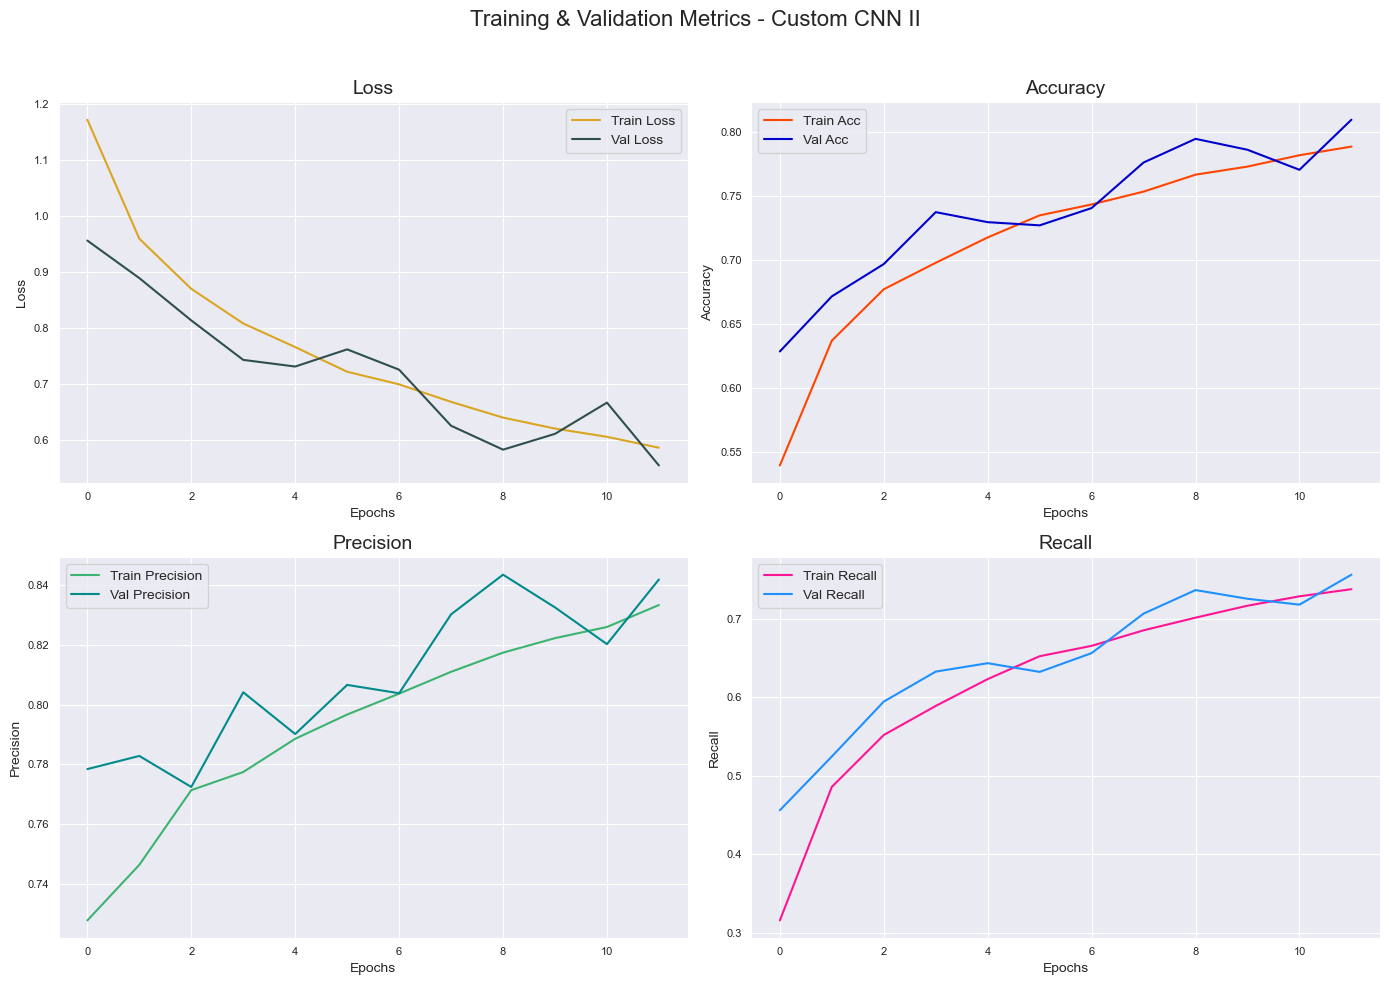

In [151]:
# === Plot Training vs Validation Metrics (Custom CNN II) ===
import seaborn as sns
sns.set_style('darkgrid')

# Create 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training & Validation Metrics - Custom CNN II', fontsize=16)

# Plot 1: Loss
axs[0, 0].plot(history_v2.history['loss'], label='Train Loss', color='goldenrod') #
axs[0, 0].plot(history_v2.history['val_loss'], label='Val Loss', color='darkslategray')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Accuracy
axs[0, 1].plot(history_v2.history['accuracy'], label='Train Acc', color='orangered')
axs[0, 1].plot(history_v2.history['val_accuracy'], label='Val Acc', color='mediumblue')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Precision
axs[1, 0].plot(history_v2.history['precision'], label='Train Precision', color='mediumseagreen')
axs[1, 0].plot(history_v2.history['val_precision'], label='Val Precision', color='darkcyan')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Recall
axs[1, 1].plot(history_v2.history['recall'], label='Train Recall', color='deeppink')
axs[1, 1].plot(history_v2.history['val_recall'], label='Val Recall', color='dodgerblue')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust legend and title font sizes for all subplots for readability
for ax in axs.flat:
    ax.legend(fontsize=10)
    ax.title.set_fontsize(14)

# Display plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit titles
plt.show()

2025-07-03 14:49:00.457485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


44/44 [==============================] - 9s 201ms/step


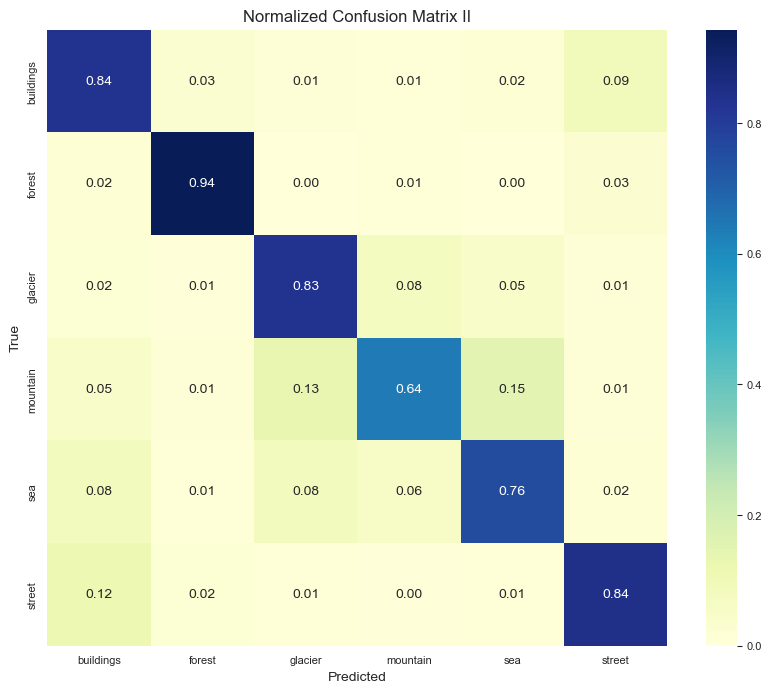

In [172]:
# === Confusion Matrix ===
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Extract true class labels from the validation generator
true_labels_v2 = validation_set_v2.classes

# Predict class probabilities for the validation set
predicted_probs_v2 = model_v2.predict(validation_set_v2, verbose=1)

# Convert probabilities to class predictions
predicted_labels_v2 = np.argmax(predicted_probs_v2, axis=1)

# Compute the confusion matrix
cm_v2 = confusion_matrix(true_labels_v2, predicted_labels_v2)

#  Normalize the confusion matrix to show percentages per class
cm_norm_v2 = cm_v2.astype('float') / cm_v2.sum(axis=1)[:, np.newaxis]

# Create labeled DataFrame for heatmap visualization
labels_v2 = list(validation_set_v2.class_indices.keys()) #get class names
df_cm_v2 = pd.DataFrame(cm_norm_v2, index=labels_v2, columns=labels_v2)

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm_v2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Normalized Confusion Matrix II')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Updated Metrics Analysis 

#### Loss & Accuracy
Training loss steadily declined across all epochs, indicating consistent learning. In contrast, validation loss dropped quickly, then fluctuated—staying below training loss for most of the run. This generally signals good generalization, but the widening gap around epoch 8 and the late rise in validation loss suggest the model began overfitting in the final stages. Compared to the first run, both losses improved and the final gap narrowed, pointing to better overall learning and prediction.

Validation accuracy started higher than training accuracy and stayed ahead until around epoch 5, when both began to converge, with validation accuracy dropping below training accuracy. By epoch 8, validation accuracy peaked—likely marking the model’s optimal generalization point. Afterward, the slight dip in validation accuracy alongside a continued rise in training accuracy further reinforces the early signs of memorization.

#### Precision & Recall
This round showed a clear improvement in precision, which was the goal when increasing training time and dropout. Validation precision consistently outperformed training precision and improved steadily across epochs. In Round 1, it lagged behind, suggesting the model was overconfident and prone to false positives. Now the model is both more cautious and more accurate.

Recall also improved, but not as dramatically. The gap between validation precision and recall (which varied between 10–15% depending on the epoch) suggests the model became more selective: correctly predicting classes more often, but occasionally missing true positives. Compared to Round 1’s high-recall, high-false-positive behavior, this shift reflects a meaningful tradeoff—lower recall in exchange for more confident, accurate predictions.

The model seems to have developed a better understanding of most core features, rather than simply getting “less bad” at guessing. Metrics support this: validation accuracy, precision, and recall all rose in meaningful ways.

#### Confusion Matrix Observations

The confusion matrix shows significant improvement in feature learning and class separation. For example, misclassifying *buildings* as *street* dropped from 16% to 9%, suggesting better differentiation between classes with overlapping context—likely due to longer training and improved focus on primary features over background noise.

However, some persistent confusion remains, particularly with the mountain class, which is still often mislabeled as glacier, sea, or even building. These errors likely stem from visual similarities like snowcaps, sharp contours, or the presence of water.

The sea class also remains a challenge, though to a lesser extent than mountain. Many sea images include mountains or snowy backgrounds, making it harder for the model to isolate class-defining features. From a background-bias perspective, this makes sense: if the model struggles to distinguish mountain from glacier, and both appear in sea-labeled images, misclassification becomes more likely. Dropout and extended training helped reduce these issues, but did not fully resolve them. At this point, the model may be approaching the limits of what it can learn from this dataset without architectural changes or cleaner, context-isolated images.

Still, across the board—and despite persistent background confusion—the confusion matrix shows fewer random misclassifications and stronger diagonal alignment. This indicates improved pattern recognition and more reliable class predictions.


#### Retraining Impact
The strategy to increase training duration and dropout was successful in nearly every intended way: better generalization, reduced false positives, and more confident predictions. It didn’t fully solve background-related confusion, but it significantly reduced its impact.

One area that didn’t improve as much as expected was the model’s confusion around background-heavy classes, especially mountain. It seems that no matter how well the model learns, background interference continues to obstruct clearer feature learning. This may require future architectural changes or more targeted augmentations.

#### Looking Ahead
This round confirmed that deeper training helped the model learn more nuanced features, and also revealed where its limits begin. While training to 12 epochs improved performance, results plateaued around epoch 8. Adding early stopping in future experiments could reduce overfitting and save time without compromising results. At this point, further tuning would likely yield diminishing returns. 

The focus now shifts to testing performance on unseen data and exploring transfer learning, to see how pretrained architectures handle the same classification problem. This round confirmed the model could learn and perform better with more time—exactly as intended. 

## Test Set Predictions

In [174]:
# Set path to test dataset 
test_path = '../data/test'

# Count number of images in each class directory
counts = [] 
class_names = os.listdir(test_path) 
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(test_path, cls))]

for class_name in class_names:
    class_path = os.path.join(test_path, class_name)
    image_files = os.listdir(class_path) 
    
    count = 0 
    
    for file in image_files:
        if os.path.isfile(os.path.join(class_path, file)):
            count += 1
    counts.append(count)
    
# Display class image counts
print(dict(zip(class_names, counts))) 


{'forest': 474, 'buildings': 437, 'glacier': 553, 'street': 501, 'mountain': 525, 'sea': 510}


In [175]:
# Prepare test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
                                    test_path,
                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                    color_mode='rgb',
                                    classes=None,
                                    class_mode='categorical',
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,  # Set to False to maintain order for predictions
                                    seed=SEED)

# Load best weights from training
model_v2.load_weights("cnn_weights_best_v2.h5")

# Evaluate model on the test set
results = model_v2.evaluate(test_set, steps=len(test_set))
test_loss, test_acc, test_precision, test_recall = results
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

Found 3000 images belonging to 6 classes.


2025-07-03 14:50:53.740270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


47/47 [==============================] - 7s 148ms/step - loss: 0.5847 - accuracy: 0.8007 - precision: 0.8299 - recall: 0.7613
Test Accuracy: 80.07%
Test Precision: 82.99%
Test Recall: 76.13%


#### Model Performance Notes

For a custom CNN with a relatively simple architecture and moderate augmentation, this is a strong result. The retraining strategy—particularly the extended training duration and adjusted dropout—clearly helped improve generalization and reduce overfitting.

**Test Accuracy**: The model correctly classified 80% of all test images, indicating reliable performance on unseen data.

**Test Precision**: 83% of predicted labels were correct, meaning the model avoided frequent false positives. But with lower recall, this precision came at the cost of missing relevant images.

**Test Recall**: The model retrieved 76% of the actual class labels, meaning it missed nearly a quarter of relevant samples. This drop reflects a precision-recall imbalance: the model favored confident predictions and avoided uncertainty leading to better precision but lower recall.

### Generating Predictions 

2025-07-17 11:58:24.605795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


47/47 [==============================] - 8s 151ms/step


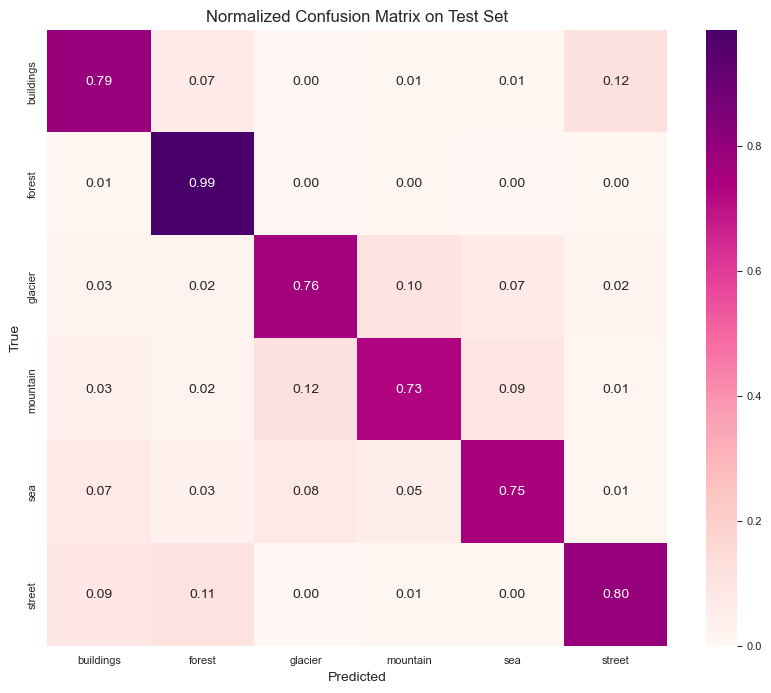

In [255]:
# === Confusion Matrix ===

# Extract true class labels from the test generator
true_labels_test = test_set.classes

# Predict class probabilities for the test set
predicted_probs_test = model_v2.predict(test_set, verbose=1)

# Convert probabilities to class predictions
predicted_labels_test = np.argmax(predicted_probs_test, axis=1)

# Compute the confusion matrix
test_cm = confusion_matrix(true_labels_test, predicted_labels_test)

# Normalize the confusion matrix to show percentages per class
test_cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]

# Create labeled DataFrame for heatmap visualization
test_labels = list(test_set.class_indices.keys()) #get class names
test_df_cm = pd.DataFrame(test_cm_norm, index=test_labels, columns=test_labels)

# Plot and save the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_df_cm, annot=True, fmt=".2f", cmap = "RdPu")
plt.title('Normalized Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../assets/cnn_cm_test.png', bbox_inches='tight', dpi=300)
plt.show()

### Test Set Predictions – CM Analysis

Testing the model on unseen data revealed several shifts in performance. Some classes improved: forest accuracy increased by 5%, and mountain—while still misclassified—improved by 9%. That’s significant, considering how much the model previously struggled with mountain scenes.

Other classes saw minor dips. Street, building, and glacier all dropped slightly in test performance compared to validation. However, these weren’t random mistakes—they followed the same confusion patterns we’ve seen before. Buildings and streets continued to be mixed up, and glacier was still occasionally misclassified as mountain. 

These patterns stem from the dataset’s background context issues: classes often appear inside one another’s environments, and some (like glacier and mountain) share similar shapes and textures. So while misclassifications persisted, they remained predictable and explainable.

Despite these shifts, the model generalized well. There was no dramatic performance drop, and no signs of overfitting— if anything, the model held steady. Test accuracy stayed consistent with validation, suggesting that what the model learned actually carried over to new data.

Next, we’ll shift focus from metrics to visuals to better understand how the model interprets and classifies different scenes.


### Correct Prediction Visualization 

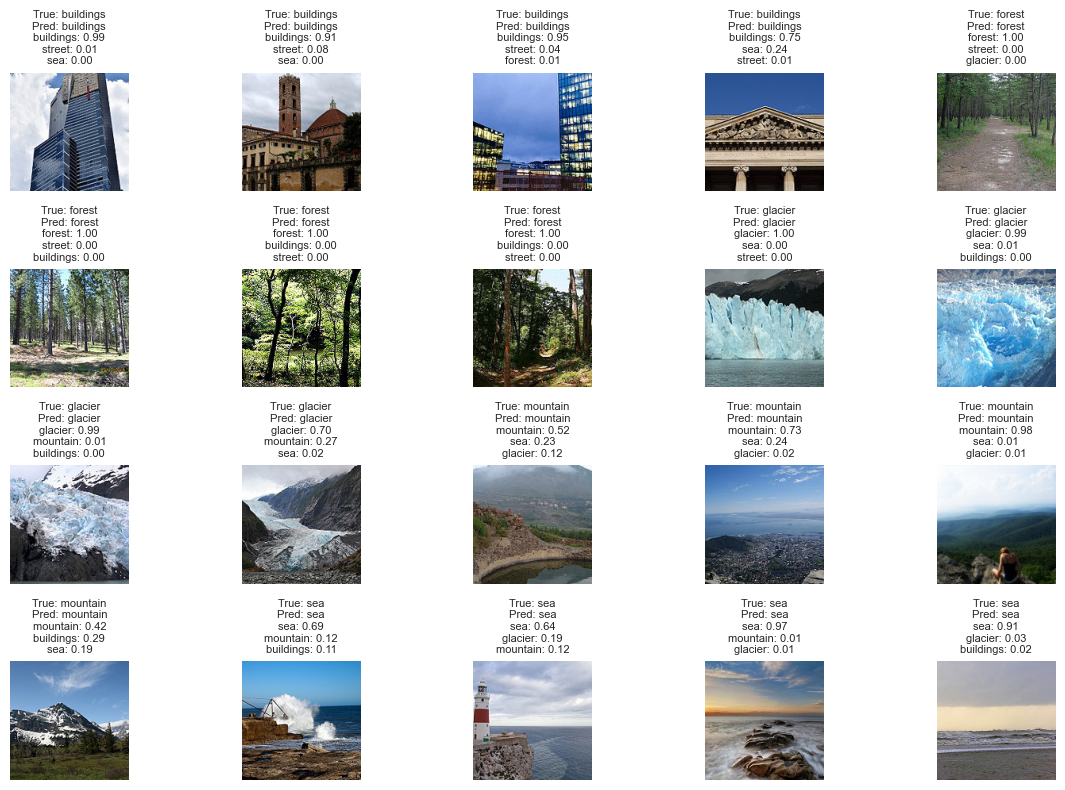

In [200]:
from tensorflow.keras.utils import load_img

# Get class names and initialize class counter for images
class_names = list(test_set.class_indices.keys())
imgs_per_class = {class_name: 0 for class_name in class_names} #limit to 4 images per class to ensure variety 

# Create 4x5 grid for displaying images 
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
axes = axes.flatten() 
count = 0  # Track total images shown

# Loop through test set and collect correctly predicted samples
for i in range(len(test_set.filenames)):
    if count == 20:
        break
        
    true_label_idx = test_set.classes[i] 
    pred_label_idx = predicted_labels_test[i] 
    
    # Check for correct predictions
    if true_label_idx == pred_label_idx: 
        class_name = class_names[true_label_idx]
        if imgs_per_class[class_name] < 4:
            img_path = test_set.filepaths[i]
            img = load_img(img_path) 
            
            # Get top-3 predicted class probabilities
            top3 = np.argsort(predicted_probs_test[i])[::-1][:3]  
            top_preds = "\n".join([f"{class_names[idx]}: {predicted_probs_test[i][idx]:.2f}" for idx in top3])

            # Display image with labels and top 3 predictions
            axes[count].imshow(img)
            axes[count].axis('off')
            axes[count].set_title(
                f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}\n{top_preds}",
                fontsize=8
            )
            imgs_per_class[class_name] += 1
            count += 1

plt.tight_layout()
plt.show()

### Incorrect Prediction Visualization

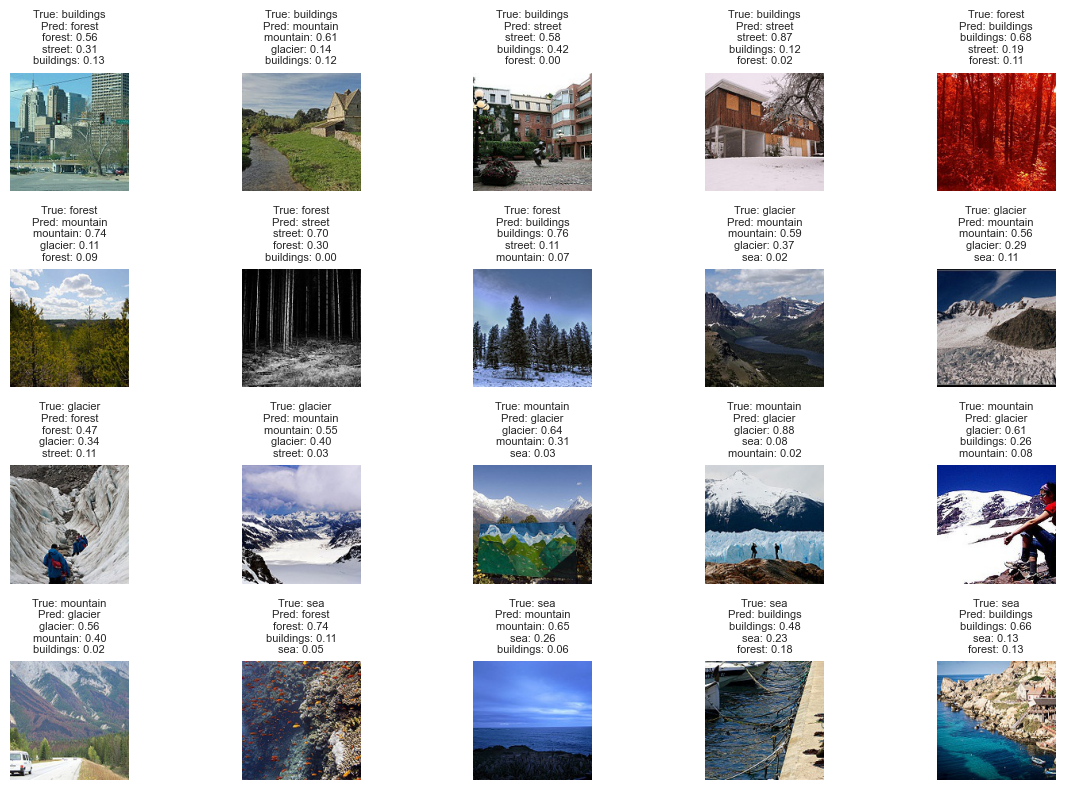

In [203]:
# Get class names and initialize class counter for images
class_names = list(test_set.class_indices.keys())
imgs_per_class = {class_name: 0 for class_name in class_names} #limit to 4 images per class to ensure variety 

# Create 4x5 grid for displaying images 
fig, axes = plt.subplots(4, 5, figsize=(12, 8)) 
axes = axes.flatten() 
count = 0 # Track total images shown

# Loop through test set and collect incorrectly predicted samples
for i in range(len(test_set.filenames)):
    if count == 20:
        break
        
    true_label_idx = test_set.classes[i] 
    pred_label_idx = predicted_labels_test[i] 
    
    # Check for incorrect predictions
    if true_label_idx != pred_label_idx: 
        class_name = class_names[true_label_idx]
        if imgs_per_class[class_name] < 4:
            img_path = test_set.filepaths[i] 
            img = load_img(img_path) 
            
            # Get top-3 predicted class probabilities
            top3 = np.argsort(predicted_probs_test[i])[::-1][:3]  
            top_preds = "\n".join([f"{class_names[idx]}: {predicted_probs_test[i][idx]:.2f}" for idx in top3])

            # Display image with labels and top 3 predictions
            axes[count].imshow(img)
            axes[count].axis('off')
            axes[count].set_title(
                f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}\n{top_preds}",
                fontsize=8
            )
            imgs_per_class[class_name] += 1
            count += 1

plt.tight_layout()
plt.show()

### Prediction Sample Reflections

The misclassified image samples reveal a clear pattern: the model leans heavily on background context to make its decisions. When images contain clean, isolated subjects (like a wide shot of the sea or a mountain without snowcaps or nearby water), predictions tend to be spot-on. But once the background gets noisy with overlapping elements like buildings, snowy peaks, or coastal backdrops, the model starts second-guessing. This suggests that it’s relying more on environmental cues rather than on the actual subject itself.

This behavior showed up in both correct and incorrect predictions, reinforcing the idea that background bias remains a persistent challenge for this dataset. While deeper training helped reduce random guesses and improved overall accuracy, the model still struggles when classes coexist in shared visual contexts. These insights confirm earlier confusion matrix observations and point to future improvements needing either architectural changes or data-centric strategies like: smarter augmentation and minimizing background cues that distract the model.

## Transfer Learning with VGG16

In [210]:
# Same augmentation pipeline as custom CNN, but with VGG16-compatible preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input

pretrained_train_datagen = ImageDataGenerator(
                                    rotation_range=15, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    fill_mode='nearest',
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input, 
                                    validation_split=0.2
                                    )

In [230]:
# Generate augmented image batches for training and validation

train_set_vgg = pretrained_train_datagen.flow_from_directory(
        path,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=SEED
)

validation_set_vgg = pretrained_train_datagen.flow_from_directory(
        path,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False, #set to false after training for cm predictions
        seed=SEED
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [213]:
# Import and load a pre-trained VGG16 model

from tensorflow.keras.applications import VGG16

# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    
vgg_conv.summary() #get model_summary 

<keras.engine.input_layer.InputLayer object at 0x178bd4b50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17baaf950> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17cb43e10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17baac550> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17baafa10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17baafcd0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17ac2a2d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17ad12450> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17ad12790> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17ac281d0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17ac2b7d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17d1f5050> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x17d1f7550> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x178ef5a

In [215]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the final model: VGG base + custom classifier head
vgg16_model = Sequential([

    vgg_conv, # pretrained convolutional base
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.4),  # slightly reduced dropout for pretrained stability
    Dense(NUMCLASSES, activation='softmax')
        
])


# Show model architecture and trainable parameters
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 15,246,150
Trainable params: 7,610,886
Non-trainable params: 7,635,264
___________________________________

In [216]:
# === Model Compilation ===

from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.metrics import Precision, Recall

vgg16_model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = RMSprop(learning_rate =1e-4) , 
    metrics = ['accuracy', Precision(), Recall()]
    )
 
# Set training duration 
num_epochs = 8 



In [217]:
# === Setup: Save the best model weights during training ===

from tensorflow.keras.callbacks import ModelCheckpoint


# Define a callback to monitor validation loss and save the best model weights
vgg16_checkpoint = ModelCheckpoint(
    '../models/vgg16_weights_best.h5',  # Filepath to save the best weights
    save_best_only=True,                # Save only if validation loss improves(decreases)
    monitor='val_loss',         
    mode='min',                         # Lower val_loss = better
    verbose=1                           # Print update when a new best model is saved
)

# === Train the model ===
vgg16_history = vgg16_model.fit(
    train_set_vgg,
    steps_per_epoch=len(train_set_vgg),
    epochs=num_epochs,
    validation_data=validation_set_vgg,
    validation_steps=len(validation_set_vgg),
    verbose=1,
    callbacks=[vgg16_checkpoint]
)

# === Save final weights after training completes ===
vgg16_model.save_weights("../models/vgg16_weights_final.h5")
print(f"Saved model weights after {num_epochs} epochs.")


# === Save the full model (architecture + weights + training config) ===
vgg16_model.save("../models/vgg16_model_v2.h5")
print("Full model saved successfully.")


Epoch 1/8


2025-07-08 11:54:13.414561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


176/176 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.8093 - precision_1: 0.8541 - recall_1: 0.7650

2025-07-08 12:08:02.607711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.34924, saving model to vgg16_weights_best.h5
176/176 [==============================] - 939s 5s/step - loss: 0.6137 - accuracy: 0.8093 - precision_1: 0.8541 - recall_1: 0.7650 - val_loss: 0.3492 - val_accuracy: 0.8887 - val_precision_1: 0.9075 - val_recall_1: 0.8541
Epoch 2/8
176/176 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8940 - precision_1: 0.9105 - recall_1: 0.8761
Epoch 2: val_loss improved from 0.34924 to 0.28523, saving model to vgg16_weights_best.h5
176/176 [==============================] - 632s 4s/step - loss: 0.3321 - accuracy: 0.8940 - precision_1: 0.9105 - recall_1: 0.8761 - val_loss: 0.2852 - val_accuracy: 0.9094 - val_precision_1: 0.9283 - val_recall_1: 0.8859
Epoch 3/8
176/176 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.9139 - precision_1: 0.9253 - recall_1: 0.9018
Epoch 3: val_loss did not improve from 0.28523
176/176 [==============================] - 641s 4s/step - lo

In [218]:
# === Save training history to file ===
import pickle

with open('../results/vgg_training_history.pkl', 'wb') as f:
    pickle.dump(vgg16_history.history, f)

print("Training history saved successfully.")


Training history saved successfully.


In [219]:
# Preview metric keys to prepare for plotting
vgg16_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

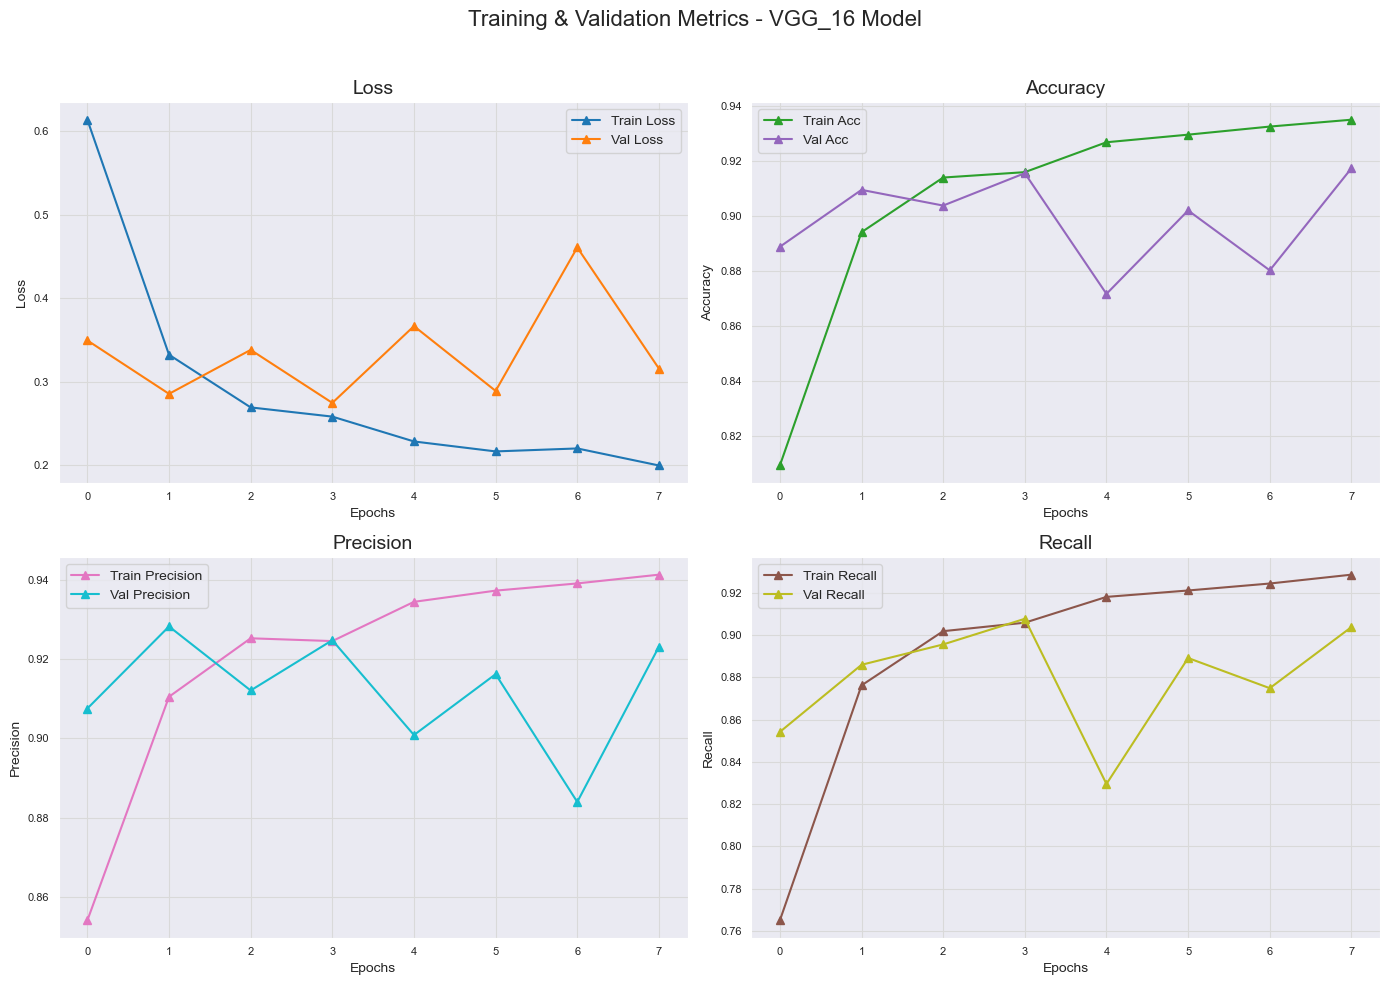

In [228]:
# === Plot Training vs Validation Metrics (VGG16) ===
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".85"})

# Create 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training & Validation Metrics - VGG_16 Model', fontsize=16)

# Plot 1: Loss
axs[0, 0].plot(vgg16_history.history['loss'], label='Train Loss', color='#1f77b4',marker='^') 
axs[0, 0].plot(vgg16_history.history['val_loss'], label='Val Loss', color='#ff7f0e',marker='^')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Accuracy
axs[0, 1].plot(vgg16_history.history['accuracy'], label='Train Acc', color='#2ca02c',marker='^')
axs[0, 1].plot(vgg16_history.history['val_accuracy'], label='Val Acc', color='#9467bd',marker='^')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Precision
axs[1, 0].plot(vgg16_history.history['precision_1'], label='Train Precision', color='#e377c2',marker='^')
axs[1, 0].plot(vgg16_history.history['val_precision_1'], label='Val Precision', color='#17becf',marker='^')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Recall
axs[1, 1].plot(vgg16_history.history['recall_1'], label='Train Recall', color='#8c564b',marker='^')
axs[1, 1].plot(vgg16_history.history['val_recall_1'], label='Val Recall', color='#bcbd22',marker='^')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()
axs[1, 1].grid(True)


# Adjust legend and title font sizes for all subplots for readability
for ax in axs.flat:
    ax.legend(fontsize=10)
    ax.title.set_fontsize(14)

# Display plot 
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit titles
plt.show()

2025-07-08 18:41:50.417541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


44/44 [==============================] - 126s 3s/step


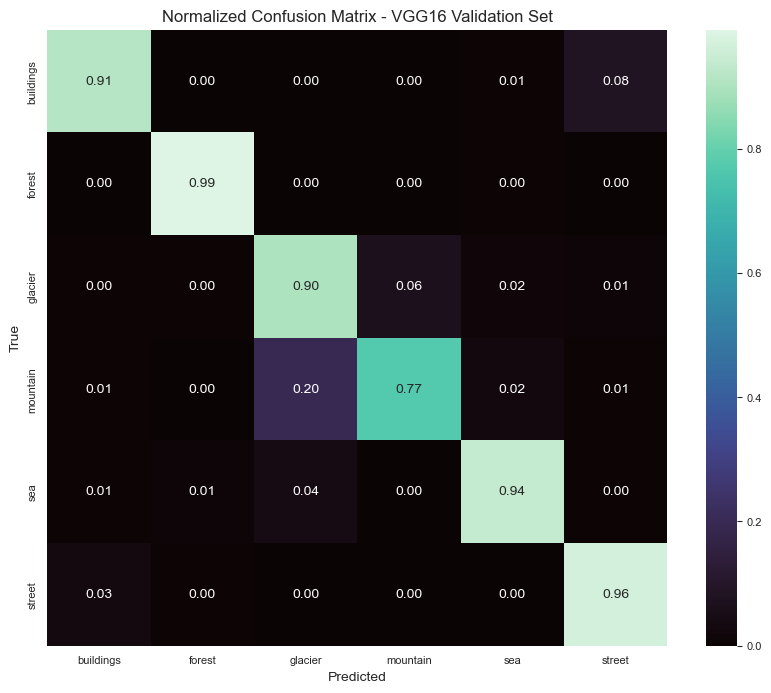

In [233]:
# === VGG16 Validation Confusion Matrix ===

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Extract true class labels from the validation generator
vgg16_true_labels = validation_set_vgg.classes

# Predict class probabilities for the validation set
vgg16_pred_probs = vgg16_model.predict(validation_set_vgg, verbose=1)

# Convert probabilities to class predictions
vgg16_pred_labels = np.argmax(vgg16_pred_probs, axis=1)

# Compute the confusion matrix
vgg16_cm = confusion_matrix(vgg16_true_labels, vgg16_pred_labels)

#  Normalize the confusion matrix to show percentages per class
vgg16_cm_norm = vgg16_cm.astype('float') / vgg16_cm.sum(axis=1)[:, np.newaxis]

# Create labeled DataFrame for heatmap visualization
vgg16_labels = list(validation_set_vgg.class_indices.keys()) #get class names
df_cm_vgg16 = pd.DataFrame(vgg16_cm_norm, index=vgg16_labels, columns=vgg16_labels)

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm_vgg16, annot=True, fmt=".2f", cmap="mako")
plt.title('Normalized Confusion Matrix - VGG16 Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### VGG16 Validation Performance Evaluation

As expected, the VGG16 model delivered stronger performance across almost every class compared to the custom CNN baseline, with a steady drop in training loss to match. However, validation metrics began to fluctuate after the fourth epoch, suggesting that most meaningful learning had already occurred. This is because VGG16, as a pretrained model, learns quickly and picks up key features early in training. Beyond that point, additional epochs contributed little additional learning, leading to small shifts in validation metrics as the model attempted to fine-tune features it had already generalized well.

The confusion matrix shows that most classes were classified with minimal error. VGG16 excelled at distinguishing between visually distinct categories like forest, sea, and street, reaching class-level accuracies above 90% in these cases.

Forest, in particular, was almost perfectly classified (0.99), highlighting how effectively the pretrained features captured texture and color-based distinctions—something the custom CNN struggled to do consistently. Even building and street, which previously confused the custom model due to shared urban features, were also better handled, with much less cross-confusion.

However, the mountain–glacier confusion remains. The model frequently confuses mountains for glaciers and vice versa, with about 20% of mountain images predicted as glacier. This confusion is explainable and unsurprising.

During later analysis, it became clear that the dataset contains ambiguous images—particularly in the glacier and mountain classes, which often share visual features. Some images labeled as 'glacier' appear to depict snowy mountains without clear ice masses, often indistinguishable from the snow-tipped mountain class images. This likely contributed to the model’s consistent confusion between the two.  

This challenge reinforces one of the project’s key takeaways: real-world data rarely arrives clean or separable. A successful model needs to generalize across ambiguity — not around it. That said, VGG16 ultimately outperformed the custom CNN, particularly in its ability to generalize beyond noisy training data. 

## Test Set Evaluation: VGG16


In [235]:
# Prepare test data (no augmentation)
vgg16_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


vgg16_test_set = vgg16_test_datagen.flow_from_directory(
                                    test_path,
                                    target_size=(INPUT_SIZE, INPUT_SIZE),
                                    color_mode='rgb',
                                    classes=None,
                                    class_mode='categorical',
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,  # Set to False to keep the order of predictions,
                                    seed=SEED)

# Load best weights from training
vgg16_model.load_weights("../models/vgg16_weights_best.h5")

# Evaluate the vgg16 model on the test set
results = vgg16_model.evaluate(vgg16_test_set, steps=len(vgg16_test_set))
test_loss, test_acc, test_precision, test_recall = results
print(f"VGG16 Test Accuracy: {test_acc * 100:.2f}%")
print(f"VGG16 Test Precision: {test_precision * 100:.2f}%")
print(f"VGG16 Test Recall: {test_recall * 100:.2f}%")
print(f"VGG16 Test Loss: {test_loss * 100:.2f}%")

Found 3000 images belonging to 6 classes.


2025-07-10 13:41:27.097786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


47/47 [==============================] - 132s 3s/step - loss: 0.2945 - accuracy: 0.9133 - precision_1: 0.9192 - recall_1: 0.9107
VGG16 Test Accuracy: 91.33%
VGG16 Test Precision: 91.92%
VGG16 Test Recall: 91.07%
VGG16 Test Loss: 29.45%


### Generating Predictions

2025-07-17 11:53:32.394437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


47/47 [==============================] - 124s 3s/step


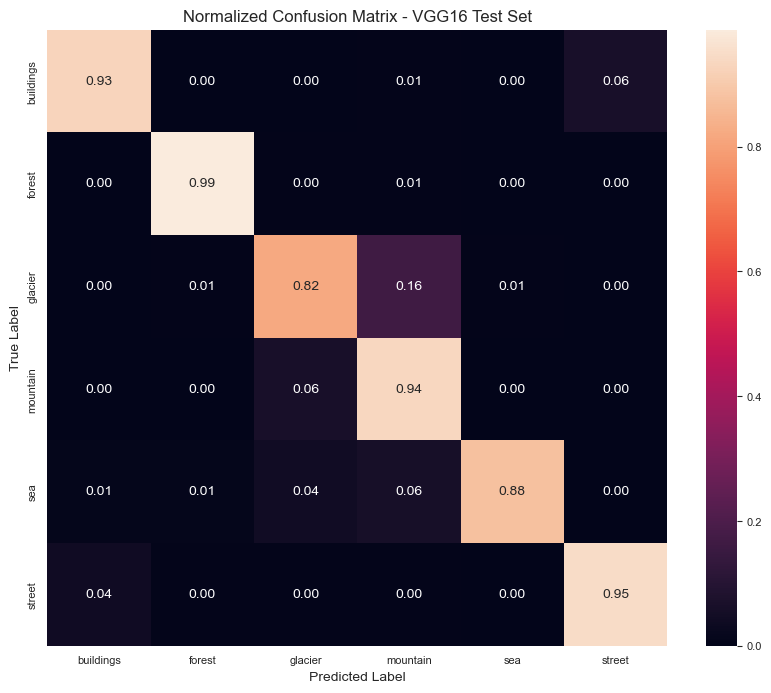

In [254]:
# === VGG16 Test Confusion Matrix ===

# Extract true class labels from test set generator
y_true_test = vgg16_test_set.classes

# Predict class probabilities for the test set
y_probs_test = vgg16_model.predict(vgg16_test_set, verbose=1)

# Convert probabilities to class predictions
y_pred_test = np.argmax(y_probs_test, axis=1)

# Compute the confusion matrix
cm_test_raw = confusion_matrix(y_true_test, y_pred_test)

# Normalize the confusion matrix to show percentages per class
cm_test_norm = cm_test_raw.astype('float') / cm_test_raw.sum(axis=1)[:, np.newaxis]

# Create labeled DataFrame for heatmap visualization
class_labels = list(vgg16_test_set.class_indices.keys()) #get class names
cm_df_test = pd.DataFrame(cm_test_norm, index=class_labels, columns=class_labels)

# Plot and save the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_test, annot=True, fmt=".2f", cmap="rocket")
plt.title('Normalized Confusion Matrix - VGG16 Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('../assets/vgg16_cm_test.png', bbox_inches='tight', dpi=300)
plt.show()


### VGG16 Accuracy Checkpoint: Correct Classifications

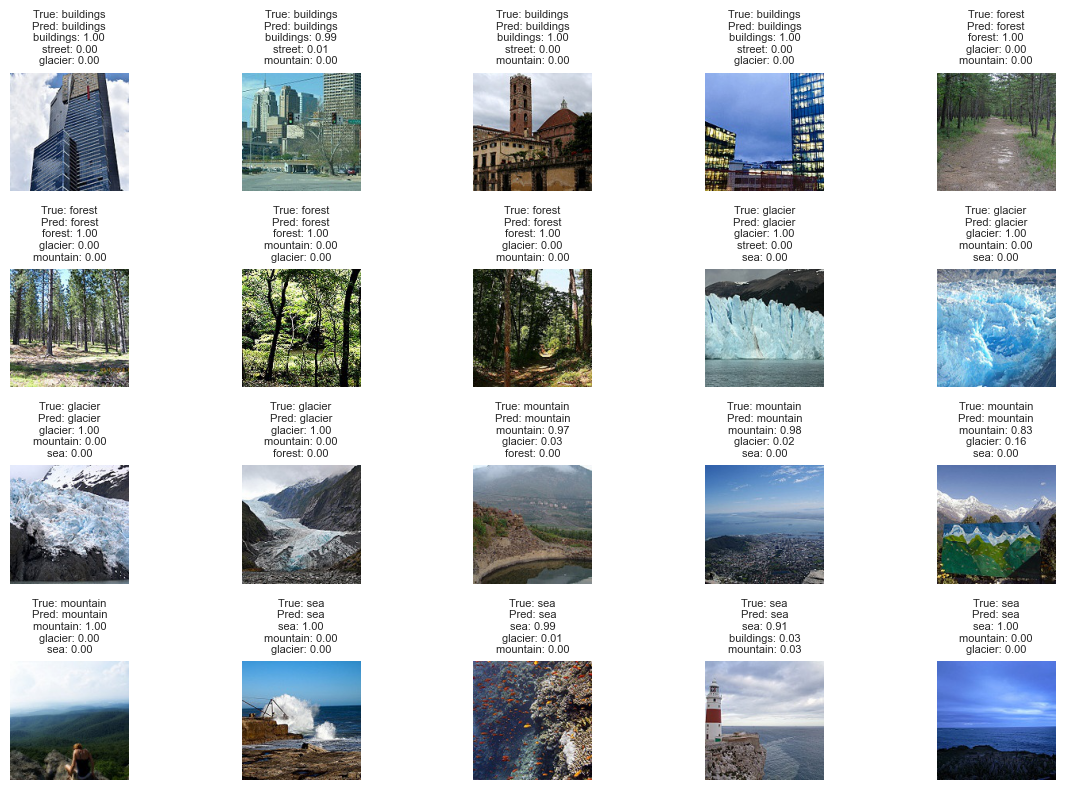

In [237]:
# Get class names and initialize class counter for images
class_names = list(vgg16_test_set.class_indices.keys())
imgs_per_class = {class_name: 0 for class_name in class_names} #limit to 4 images per class to ensure variety 

# Create 4x5 grid for displaying images 
fig, axes = plt.subplots(4, 5, figsize=(12, 8)) 
axes = axes.flatten() 
count = 0 # Track total images shown

# Loop through test set and collect correctly predicted samples
for i in range(len(vgg16_test_set.filenames)):
    if count == 20:
        break
        
    true_label_idx = vgg16_test_set.classes[i] 
    pred_label_idx = y_pred_test[i]

    # Check for correct predictions
    if true_label_idx == pred_label_idx: 
        class_name = class_names[true_label_idx]
        if imgs_per_class[class_name] < 4:
            img_path = vgg16_test_set.filepaths[i] 
            img = load_img(img_path)
            
            # Get top-3 predicted class probabilities
            top3 = np.argsort(y_probs_test[i])[::-1][:3] 
            top_preds = "\n".join([f"{class_names[idx]}: {y_probs_test[i][idx]:.2f}" for idx in top3])

            # Display image with labels and top 3 predictions
            axes[count].imshow(img)
            axes[count].axis('off')
            axes[count].set_title(
                f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}\n{top_preds}",
                fontsize=8
            )
            imgs_per_class[class_name] += 1
            count += 1

plt.tight_layout()
plt.show()

### VGG16 Accuracy Checkpoint: Incorrect Classifications

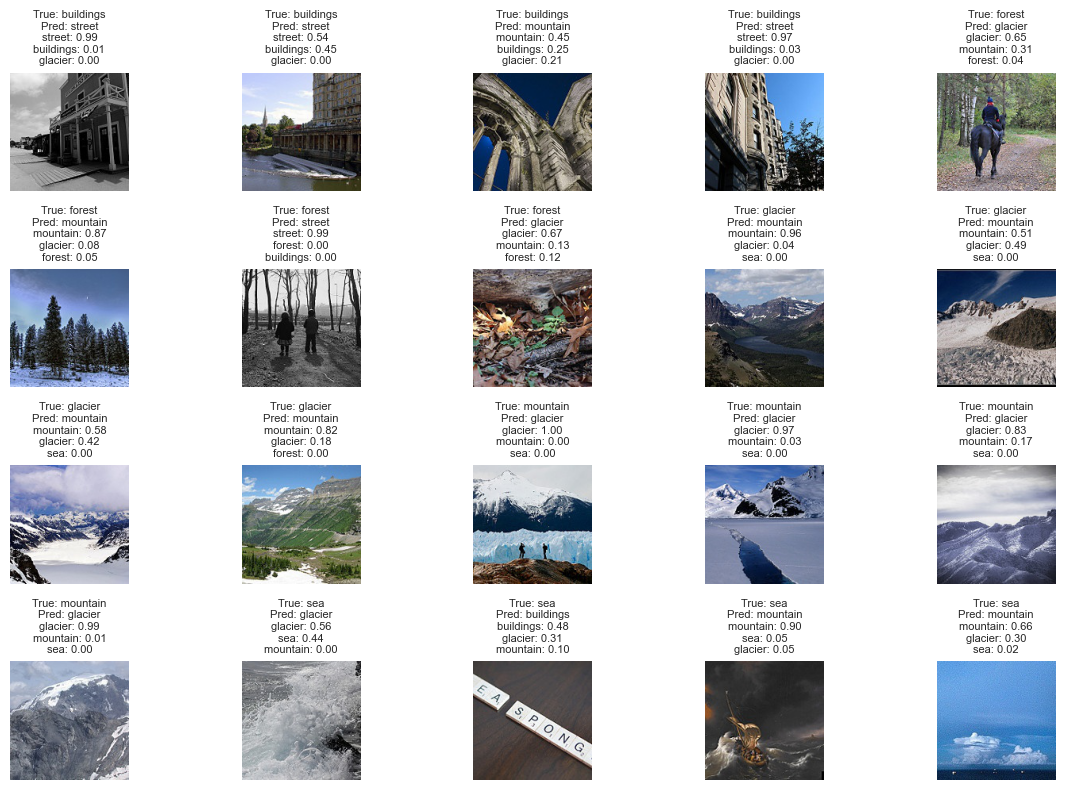

In [239]:
# Get class names and initialize class counter for images
class_names = list(vgg16_test_set.class_indices.keys())
imgs_per_class = {class_name: 0 for class_name in class_names} #limit to 4 images per class to ensure variety 

# Create 4x5 grid for displaying images 
fig, axes = plt.subplots(4, 5, figsize=(12, 8)) 
axes = axes.flatten() 
count = 0 # Track total images shown

# Loop through test set and collect incorrectly predicted samples
for i in range(len(vgg16_test_set.filenames)):
    if count == 20:
        break
        
    true_label_idx = vgg16_test_set.classes[i] 
    pred_label_idx = y_pred_test[i] 

    # Check for incorrect predictions
    if true_label_idx != pred_label_idx: 
        class_name = class_names[true_label_idx]
        if imgs_per_class[class_name] < 4:
            img_path = vgg16_test_set.filepaths[i] 
            img = load_img(img_path) 
            
            # Get top-3 predicted class probabilities
            top3 = np.argsort(y_probs_test[i])[::-1][:3]  
            top_preds = "\n".join([f"{class_names[idx]}: {y_probs_test[i][idx]:.2f}" for idx in top3])

            # Display image with labels and top 3 predictions
            axes[count].imshow(img)
            axes[count].axis('off')
            axes[count].set_title(
                f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]}\n{top_preds}",
                fontsize=8
            )
            imgs_per_class[class_name] += 1
            count += 1

plt.tight_layout()
plt.show()

## VGG16 Test Performance Evaluation 

VGG16's performance on unseen data remained largely consistent with its validation results, with the exception of the glacier and sea classes—both of which saw declines in classification accuracy by 8% and 6%, respectively. As anticipated, this drop aligns with earlier observations: glacier is still often misclassified as mountain, and sea continues to confuse the model when mountain or glacier features bleed into the background.

However, the mountain class saw a 17% boost in classification accuracy compared to prior runs. While some confusion with glacier persists, it is significantly reduced relative to the custom CNN—suggesting that the pretrained architecture is better at handling overlapping visual features.

A test loss of 29.45% is higher than ideal for a pretrained model but not unexpected, given the inconsistencies present in the dataset. Nonetheless, high accuracy, precision, and recall indicate that the model remains stable and performs with confidence on most test cases.

Some shakiness still remains, but that’s expected when working with messy, real-world data. This dataset reflects the kind of imperfect conditions most deployed systems face where many variables can’t be neatly controlled. We can guide what a model learns, but we can’t dictate what it pays attention to—especially in a dataset where background features are loud enough to mislead it. 




## Final Model Comparison: Custom CNN vs. VGG16  

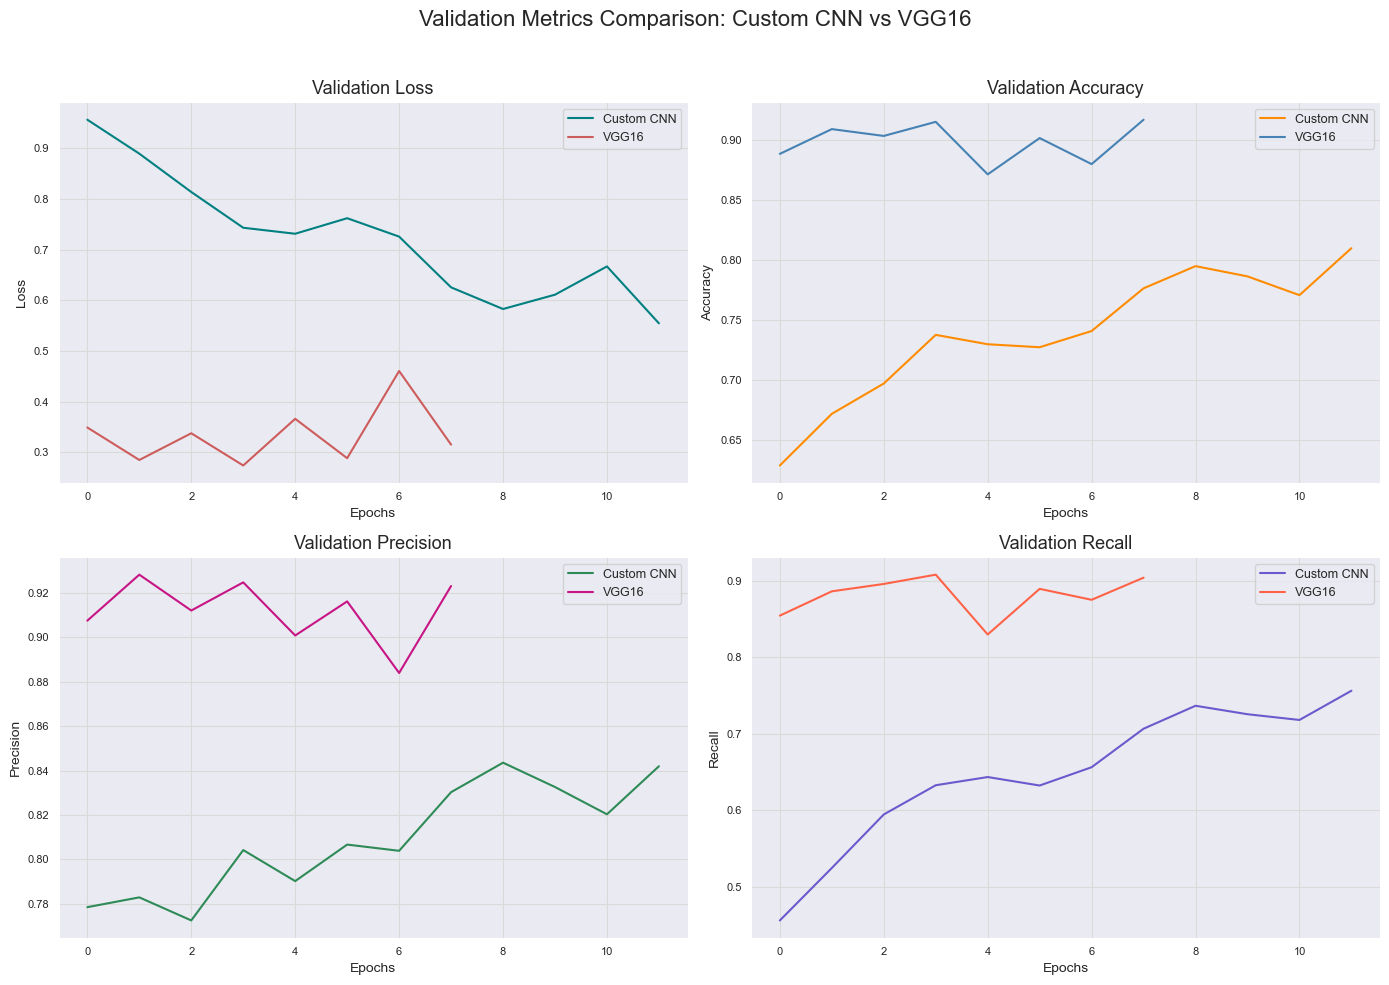

In [256]:
# === Side-by-Side Validation Trends for Custom CNN and VGG16 ===

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Validation Metrics Comparison: Custom CNN vs VGG16', fontsize=16)

# Plot 1: Validation Loss
axs[0, 0].plot(history_v2.history['val_loss'], label='Custom CNN', color='teal')
axs[0, 0].plot(vgg16_history.history['val_loss'], label='VGG16', color='indianred')
axs[0, 0].set_title('Validation Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot 2: Validation Accuracy
axs[0, 1].plot(history_v2.history['val_accuracy'], label='Custom CNN', color='darkorange')
axs[0, 1].plot(vgg16_history.history['val_accuracy'], label='VGG16', color='steelblue')
axs[0, 1].set_title('Validation Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot 3: Validation Precision
axs[1, 0].plot(history_v2.history['val_precision'], label='Custom CNN', color='seagreen')
axs[1, 0].plot(vgg16_history.history['val_precision_1'], label='VGG16', color='mediumvioletred')
axs[1, 0].set_title('Validation Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot 4: Validation Recall
axs[1, 1].plot(history_v2.history['val_recall'], label='Custom CNN', color='slateblue')
axs[1, 1].plot(vgg16_history.history['val_recall_1'], label='VGG16', color='tomato')
axs[1, 1].set_title('Validation Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

# Adjust legend and title font sizes for all subplots for readability
for ax in axs.flat:
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.title.set_fontsize(13)
    
# Save and display plot 
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to fit titles
plt.savefig('../assets/cnn_vs_vgg16_metrics.png', bbox_inches='tight', dpi=300)
plt.show()


### Comparative Analysis

In terms of raw performance, the pretrained VGG16 model significantly outperformed the custom CNN across every major metric. While the custom CNN showed promise during training and managed reasonable validation results, its performance dropped notably when evaluated on unseen test data. In contrast, VGG16 maintained high scores in training, validation, and testing—demonstrating better generalization under real-world conditions.

On the test set, the custom CNN achieved:

Accuracy: 80.07%
Precision: 82.99%
Recall: 76.13%

The VGG16 model, on the other hand, delivered:

Accuracy: 91.33%
Precision: 91.92%
Recall: 91.07%
Loss: 29.45%

The performance gap is substantial—VGG16 exceeded the custom CNN by over 10% in both accuracy and precision, and by 15% in recall. Clearly, VGG16 handled feature extraction more effectively and was better equipped to manage the dataset’s complexity.

That said, both models struggled with background bias, particularly among the glacier, mountain, and sea classes. This issue persisted across all phases of training and testing, confirming that the models—pretrained or not—often rely more on environmental context than on the actual class-defining elements. However, VGG16 was less derailed by these distractions, reducing misclassifications where the custom CNN failed.

The custom CNN’s main strength was its training speed and efficiency. Despite being trained over 12 epochs, it completed its training faster than VGG16’s 8. This makes it more suitable for deployment in environments with limited computational resources. Additionally, the custom CNN allowed for full architectural control, offering opportunities for experimentation and fine-tuning, though this also introduced a longer trial-and-error process.

It’s also worth noting that VGG16 plateaued early—after just four epochs—indicating how quickly pretrained models converge. In fact, those first four epochs took nearly as long to run as all 12 custom CNN epochs combined—proof that power and performance don’t always mean faster turnaround.

In conclusion, VGG16 was the better performer in nearly every aspect, particularly for generalization and classification accuracy. But the custom CNN remains valuable, especially for rapid prototyping and resource-constrained environments where flexibility and speed matter more than peak performance.

## Closing Remarks

The project aimed to design, train, and evaluate a convolutional neural network capable of accurately classifying unseen landscape images. But beyond building a high-performing model, the aim was to understand how CNNs actually behave—how they learn, where they fail, and how that behavior shifts when replacing a custom architecture with a powerful pretrained model like VGG16.

The first round of this project focused on exploratory analysis and foundational concepts. This time, I implemented and trained two CNNs from scratch, explored the impact of design decisions like layer stacking and dropout, and evaluated performance using accuracy, precision, and recall. I also integrated a pretrained VGG16 model by freezing its convolutional base layers, adding a custom classifier head, and adapting the data pipeline to match its input format.

#### Reflection and Takeaways

Side-by-side comparisons helped me analyze model behavior, especially where predictions broke down. Through confusion matrices and top-3 prediction breakdowns, I saw how both models struggled with background interference and overlapping class features. While VGG16 outperformed the custom CNN across all metrics, it came with tradeoffs: less flexibility, longer training time, reduced architectural control, and higher memory demands.

One lesson I won’t forget after losing my first plots? Save your training history and weights. Always. I also learned that simpler architectures can outperform deeper ones when the dataset is small, and that a low validation loss doesn’t always translate to better generalization. I saw firsthand how background bias can consistently derail predictions, and how balancing model complexity with performance requires experimentation, not just intuition.

Most importantly, I gained a clearer sense of how model design, training strategy, and dataset quality interact in real-world pipelines. In future work, I’d like to explore advanced augmentation, improved dataset filtering, and architectural tweaks to boost generalization.

But as it stands, this project delivered on its goal: I built and compared multiple models, evaluated their strengths and weaknesses, and walked away with a practical, hands-on understanding of how deep learning handles real-world image classification.


---